In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import os
import glob
from collections import defaultdict
import tsfel

In [2]:
sample_rate = 100 # samples/s
chunk_seconds = 1
chunk_size = chunk_seconds * sample_rate

In [3]:
data_dir = os.path.expanduser("~/Documents/Senior/Fall/Clinic/Data Cleaner/tarsalis_data_clean")
os.chdir(data_dir)
filenames = glob.glob('*.csv')

In [4]:
dataframes = [pd.read_csv(f) for f in filenames]

In [5]:
dataframes2 = []
for df in dataframes:
    df['current'] = df['current'].apply(lambda x : x.strip())
    dataframes2.append(df)

In [6]:
all_data = pd.concat(dataframes2)
np.unique(all_data['current'])

array(['AC', 'DC'], dtype=object)

In [7]:
dataframes = dataframes2

In [8]:
%matplotlib qt

In [9]:
transformed_dataframes = []

#df = dataframes[0]
for df in dataframes:
    
    num_chunks = len(df) // chunk_size
    chunks = np.array_split(df[:num_chunks*chunk_size], num_chunks)

    columns = defaultdict(list)

    #chunk = chunks[0]
    for chunk in chunks:

        # start at 1 to ignore the DC component
        chunk_fft = np.abs(fft(chunk["pre_rect"].values))[1:chunk_size//2]
        chunk_freqs = fftfreq(chunk_size, 1 / sample_rate)[1:chunk_size//2]
        
        # https://stackoverflow.com/a/20826735
        # TODO: maybe do peak extraction on FFT instead of just indices of max vals
        # Extract indices of frequencies with greatest amplitude
        num_largest = 6
        indices = (-chunk_fft).argpartition(num_largest, axis=None)[:num_largest]

        # Sort indices based on amplitudes of corresponding frequencies
        indices = sorted(indices, key=lambda x: chunk_fft[x], reverse=True)
        
        # Get the frequencies
        peak_freqs = chunk_freqs[indices]
        
        #print(peak_freqs)
        #plt.plot(chunk_freqs, chunk_fft, '.-')
        #plt.grid()
        #for i in indices:
        #    plt.axvline(chunk_freqs[i])

        labels, label_counts = np.unique(chunk["labels"], return_counts=True)
        label = labels[np.argmax(label_counts)]

        for i in range(num_largest):
            columns[f"F{i}"].append(peak_freqs[i])
        columns["mean"].append(np.mean(chunk["pre_rect"]))
        columns["std"].append(np.std(chunk["pre_rect"]))
        columns["resistance"].append(chunk["resistance"].values[0])
        columns["volts"].append(chunk["voltage"].values[0])
        columns["time"].append(chunk["time"].values[0])
        columns["current"].append(0 if chunk["current"].values[0] == "AC" else 1)
        columns["label"].append(label)
        
    df_out = pd.DataFrame(columns)

    transformed_dataframes.append(df_out)
df_out

C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,F0,F1,F2,F3,F4,F5,mean,std,resistance,volts,time,current,label
0,23.0,22.0,3.0,8.0,5.0,36.0,-0.017773,0.001225,9,75,0.0,0,NP
1,17.0,30.0,6.0,44.0,45.0,46.0,-0.017859,0.001229,9,75,1.0,0,NP
2,5.0,39.0,6.0,16.0,10.0,47.0,-0.018005,0.001308,9,75,2.0,0,NP
3,22.0,46.0,34.0,44.0,11.0,42.0,-0.017969,0.001209,9,75,3.0,0,NP
4,2.0,3.0,33.0,42.0,44.0,5.0,-0.017993,0.001059,9,75,4.0,0,NP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7746,25.0,35.0,12.0,39.0,48.0,23.0,-0.001782,0.000870,9,75,7746.0,0,NP
7747,41.0,16.0,33.0,39.0,20.0,8.0,-0.001575,0.000966,9,75,7747.0,0,NP
7748,31.0,40.0,6.0,34.0,1.0,32.0,-0.001660,0.000872,9,75,7748.0,0,NP
7749,14.0,25.0,19.0,16.0,2.0,17.0,-0.001636,0.000995,9,75,7749.0,0,NP


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [11]:
test_data = transformed_dataframes[:12]
train_data = transformed_dataframes[12:]
test = pd.concat(test_data)
train = pd.concat(train_data)

X_test = test.drop(["label"], axis=1)
Y_test = test["label"]
X_train = train.drop(["label"], axis=1)
Y_train = train["label"]

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=190)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, Y_train)
predicted = model.score(X_test, Y_test)
#scores

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [16]:
f1_score(Y_test, model.predict(X_test), average='macro')

0.39612553320357907

In [17]:
precision_score(Y_test, model.predict(X_test), average = 'macro')

C:\Users\zbtra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.5105517860037356

In [18]:
recall_score(Y_test, model.predict(X_test), average = 'macro')

0.3917208353897944

In [28]:
#scores.mean(), scores.std()
predicted

0.8493436754176611

Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix')

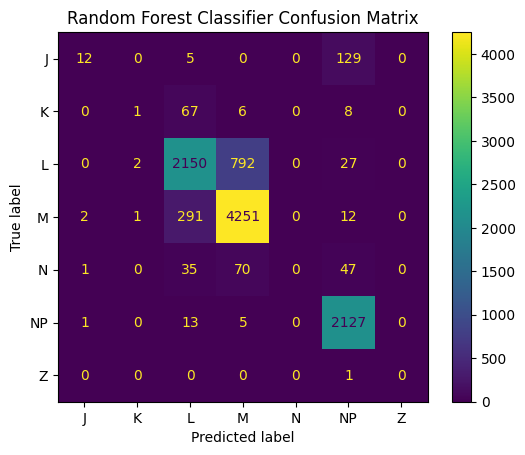

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)
plt.title("Random Forest Classifier Confusion Matrix")

In [36]:
from sklearn.metrics import f1_score
f1_score(model.predict(X_test), Y_test, average='macro')

0.3813240956247031

Make a nice plot so we can see how the classifier was classifying things

In [12]:
Y_test.unique()

array(['NP', 'J', 'K', 'L', 'M', 'N'], dtype=object)

In [56]:
label_to_color = {
    "NP": "red",
    "J": "blue",
    "K": "green",
    "L": "purple",
    "M": "pink",
    "N": "cyan",
    "Z": "orange"
}

def plot_labels(time, voltage, true_labels, pred_labels, probs = None):
    """
    plot_labels produced a matplotlib figure containing three subplots
        that visualize a waveform along with the true and predicted labels
    Input:
        time: a series of time values
        voltage: a time series of voltage values from the waveform
        true_labels: a time series of the true label for each time point
        pred_labels: a time series of the predicted labels for each time point
    Output:
        (fig, axs): a tuple
    """
    fig, axs = plt.subplots(4 if len(probs) > 0 else 3, 1, sharex = True)
    recording = 1
    fill_min, fill_max = voltage.min(), voltage.max()
    
    # First plot will be the true labels
    axs[0].plot(time, voltage, color = "black")
    for label, color in label_to_color.items():
        fill = axs[0].fill_between(time, fill_min, fill_max, 
                where = (true_labels == label), color=color, alpha = 0.5)
        fill.set_label(label)
    axs[0].legend(bbox_to_anchor=(0.5, 1), 
                  bbox_transform=fig.transFigure, loc="upper center", ncol=9)
    axs[0].set_title("True Labels")
    # Second plot will be the predicted labels
    axs[1].plot(time, voltage, color = "black")
    for label, color in label_to_color.items():
        axs[1].fill_between(time[:len(pred_labels)], fill_min, fill_max, 
                where = (pred_labels == label), color=color, alpha = 0.5)
    axs[1].set_title("Predicted Labels")
    # Third plot will be marked where there is a difference between the two
    axs[2].plot(time, voltage, color = "black")
    axs[2].fill_between(time[:len(pred_labels)], fill_min, fill_max, 
            where = (pred_labels != true_labels[:len(pred_labels)]), color = "gray", alpha = 0.5)
    axs[2].set_title("Incorrect Labels")
    if len(probs) > 0:
        # Fourth plot with confidences
        axs[3].plot(time[:len(probs)], probs)
        axs[3].set_title("Confidence")
        axs[3].set_ylim([0, 1])
        # Axes titles and such
    fig.supxlabel("Time (s)")
    fig.supylabel("Volts")
    fig.tight_layout()
    
for i in range(12):
    recording = i
    df = dataframes[recording]
    transformed_df = test_data[recording]
    pred_labels = model.predict(transformed_df.drop(["label"], axis=1)).repeat(sample_rate * chunk_seconds)
    probs = model.predict_proba(transformed_df.drop(["label"], axis=1)).max(axis=1).repeat(sample_rate * chunk_seconds)
    plot_labels(df["time"], df["pre_rect"], df["labels"], pred_labels, probs)


NameError: name 'test_data' is not defined